CLIP Guided Img2Img Stable Diffusion

CLIP guided Img2Img stable diffusion can help to generate more realistic images with an initial image by guiding stable diffusion at every denoising step with an additional CLIP model.

The following code requires roughly 12GB of GPU RAM. THis script was contributed by [Nipun Jindal](https://github.com/nipunjindal/) and the notebook by [Parag Ekbote](https://github.com/ParagEkbote).

In [1]:
pip install diffusers transformers pillow torch

Note: you may need to restart the kernel to use updated packages.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

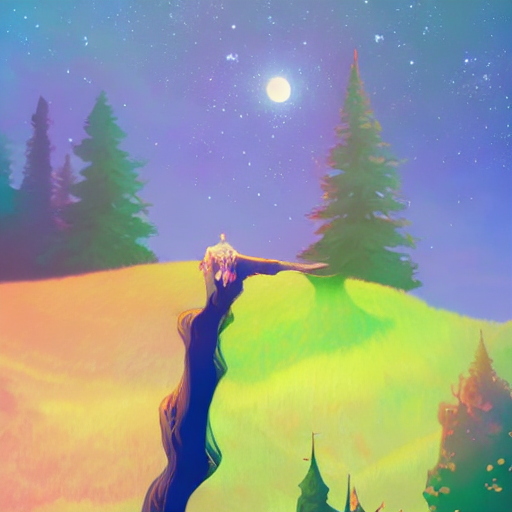

: 

In [3]:
from io import BytesIO
import requests
import torch
from diffusers import DiffusionPipeline
from PIL import Image
from transformers import CLIPImageProcessor, CLIPModel

# Load CLIP model and feature extractor
feature_extractor = CLIPImageProcessor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
)

# Load guided pipeline
guided_pipeline = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    custom_pipeline="clip_guided_stable_diffusion_img2img",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    torch_dtype=torch.float16,
)
guided_pipeline.enable_attention_slicing()
guided_pipeline = guided_pipeline.to("cuda")

# Define prompt and fetch image
prompt = "fantasy book cover, full moon, fantasy forest landscape, golden vector elements, fantasy magic, dark light night, intricate, elegant, sharp focus, illustration, highly detailed, digital painting, concept art, matte, art by WLOP and Artgerm and Albert Bierstadt, masterpiece"
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"
response = requests.get(url)
edit_image = Image.open(BytesIO(response.content)).convert("RGB")

# Run the pipeline
image = guided_pipeline(
    prompt=prompt,
    height=512,  # Height of the output image
    width=512,   # Width of the output image
    image=edit_image,  # Input image to guide the diffusion
    strength=0.75,  # How much to transform the input image
    num_inference_steps=30,  # Number of diffusion steps
    guidance_scale=7.5,  # Scale of the classifier-free guidance
    clip_guidance_scale=100,  # Scale of the CLIP guidance
    num_images_per_prompt=1,  # Generate one image per prompt
    eta=0.0,  # Noise scheduling parameter
    num_cutouts=4,  # Number of cutouts for CLIP guidance
    use_cutouts=False,  # Whether to use cutouts
    output_type="pil",  # Output as PIL image
).images[0]

# Display the generated image
image.show()
